# Deploy Django Project into Windows Server using IIS and FastCGI

* [Reference](https://blog.nonstopio.com/deploy-django-application-on-windows-iis-server-93aee2864c41)
* [How to manage static files in django](https://docs.djangoproject.com/en/4.2/howto/static-files/)

## Prepare Python env and IIS

### Python Environment Setting

* According to author's experience, `python 3.9.x` is not compatible with `FastCGI`, therefore we need to re-create a conda env with `python==3.8`
* And then, we need reinstall the required library, in a case you do not generate `requirements.txt`, we do it one by one here
* `wfastcgi` provides a bridge between IIS and Python using WSGI and FastCGI 

    ```bash
    conda create -n py38 python==3.8
    conda activate py38
    pip install django
    pip install django-allauth
    pip install django-crispy-forms
    pip install crispy-bootstrap4
    pip install jwt
    pip install et-xmlfile
    pip install requests
    pip install urllib3
    pip install wfastcgi
    pip install pillow
    ```
### Django Project Setting

* Remember to change Debug model to `False` and add Host IP into your `django_project.settings.py`
* Set `STATIC_URL`, `STATIC_ROOT`, `MEDIA_URL`, `MEDIA_ROOT`
  * Don't put any static files in the `STATIC_ROOT` directory. That's where the static files get copied to automatically after you run `collectstatic`.
  * Instead, always put them in the directories associated with the `STATICFILES_DIRS` setting or `<APP_NAME>/static/`.

    ```python
    #django_project.settings.py
    ...
    DEBUG = False
    ALLOWED_HOSTS = ['*']
    ...
    STATIC_URL = "static/"
    MEDIA_URL = '/media/'
    STATIC_ROOT = os.path.join(BASE_DIR,'static')
    MEDIA_ROOT = os.path.join(BASE_DIR,'media')
    ...
    ```

### Install IIS
1. Search **Turn Windows features on or off**, check `Internet Information Services` and `Internet Information Services Hostable Web Core`

2. Goto `Internet Information Services` > `World Wide Web Services` > `Application Development Features`, Check`CGI`
    
    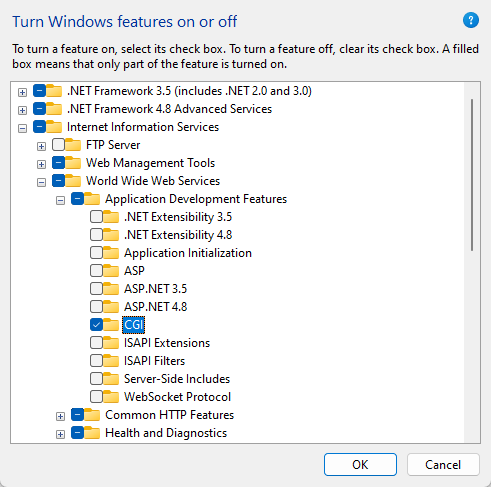

3. Click `OK` to apply this setting, and restart your machine to activate it.

### Verify the IIS Installation

* Open a web browser on the server, goto [http://localhost/](http://localhost/).You should see the default IIS page.

    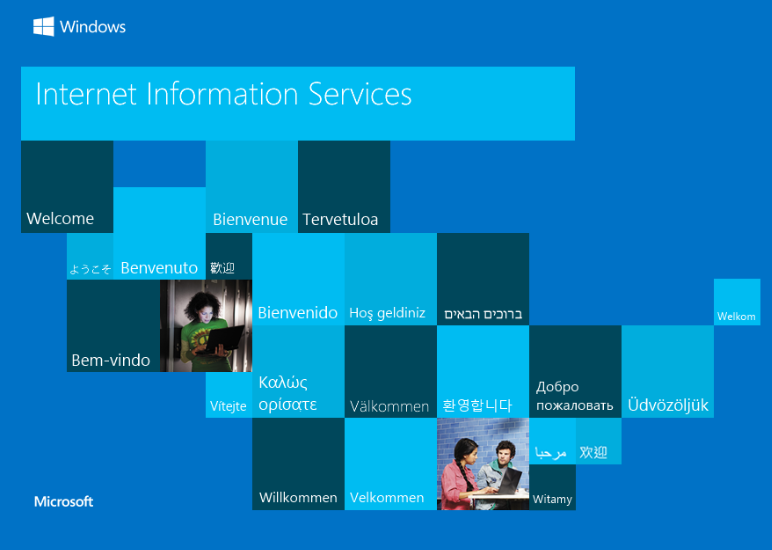

## Configure IIS 

### Option 1: Configure FastCGI using IIS

1. Click on the name of the server in the list on the left. Double-click the `FastCGI Settings` icon

    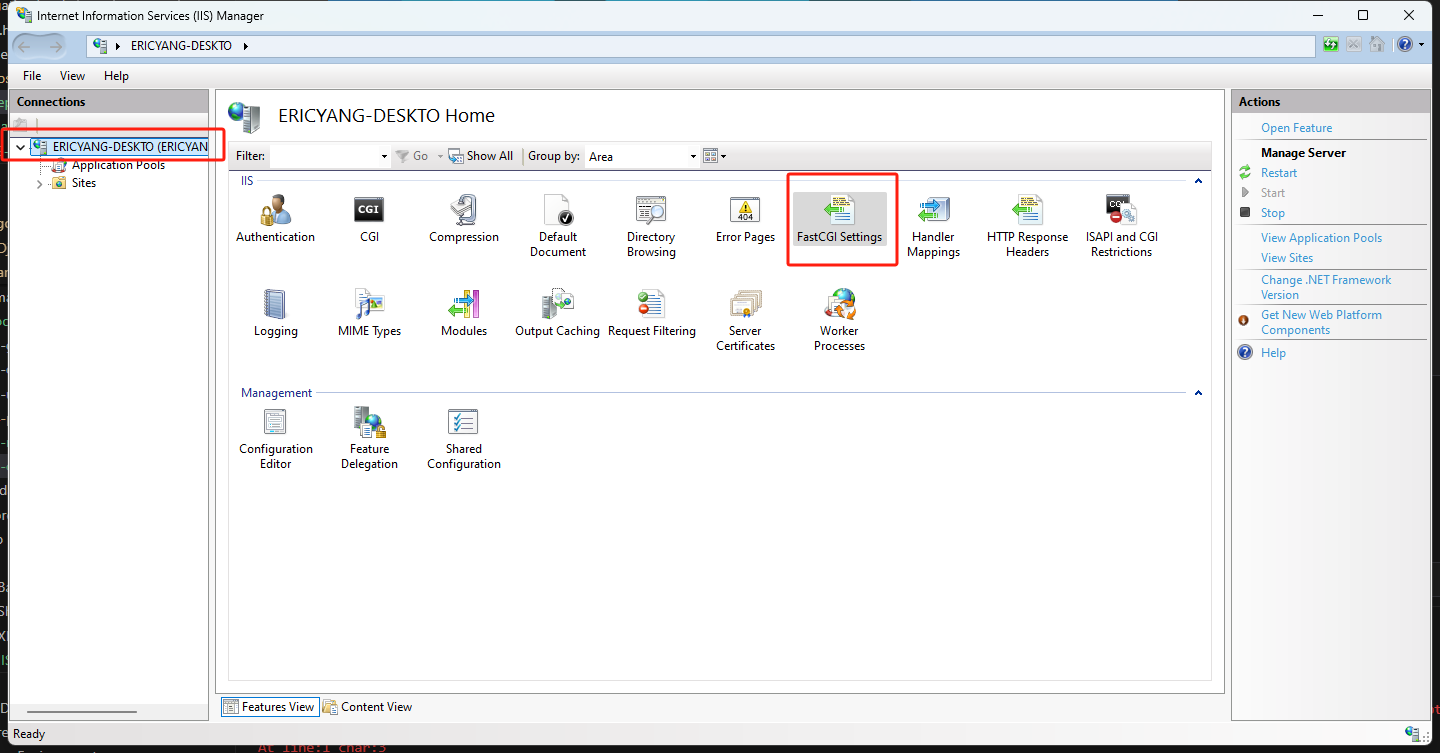

2. Under `Actions` on the right-hand side click `Add application …`

    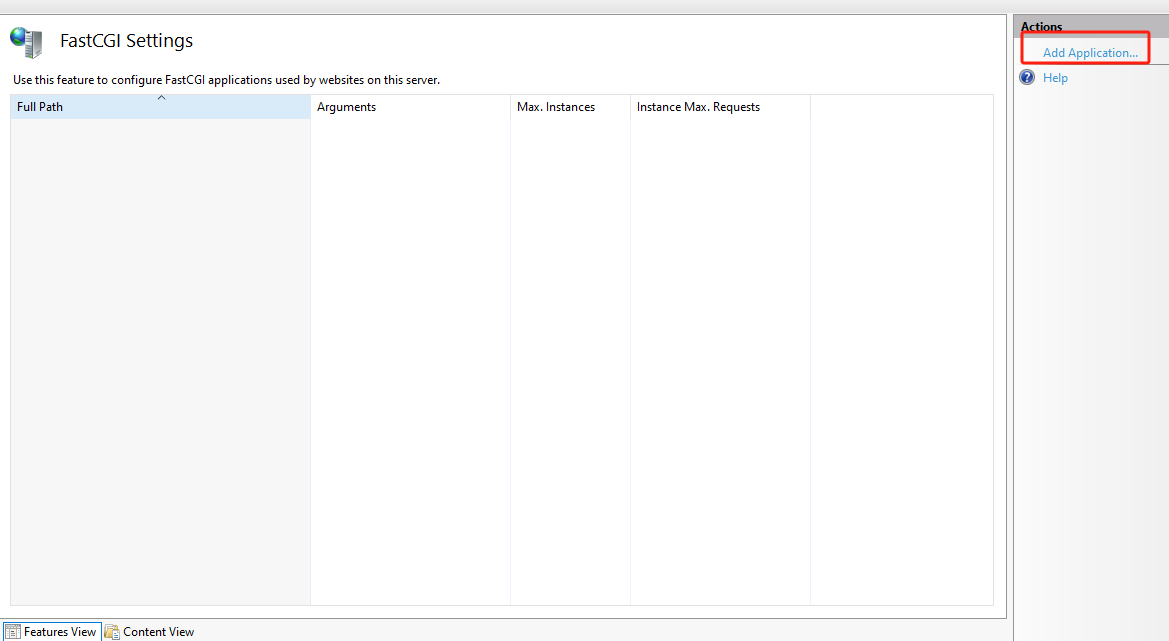
    
3. In the Add FastCGI Application dialog, in the `Full Path` box, type the path to the Python env we just created, and In the `Arguments` input box, type the path to the `wfastcgi.py` file in the `site-packages`

    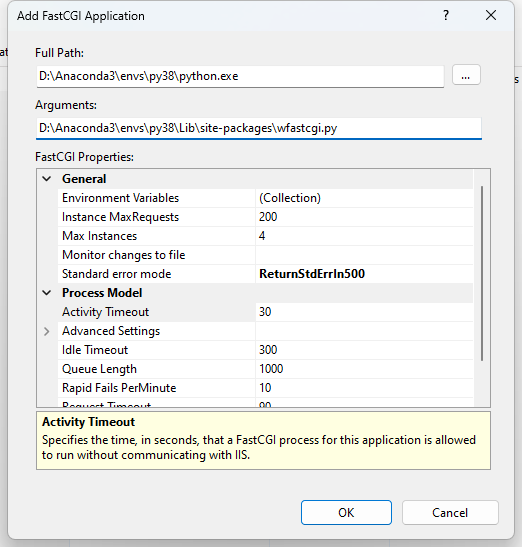
    
4.  Under the `General` section, click on the `Environment Variables` line, then click the gray `…` button that appears next to (Collection) on the right-hand side of the line.
    1.  Add `DJANGO_SETTINGS_MODULE` with value `{Your_Django_Project_name}.settings`
    2.  Add `PYTHONPATH` with value `{Your_Django_Project_Path}`
    3.  Add `WSGI_HANDLER` with value `{Your_Django_Project_name}.wsgi.application`

## Create and Configure a New IIS Web Site

Next, we need to create a new website in IIS for the Django application and add a Handler Mapping to the newly created website so that requests coming to the IIS website are passed off to the Django application for processing.

### Create a new Web Site

1. Open `IIS Manager`, Right-click on the `Sites` folder and click `Add Website …`

    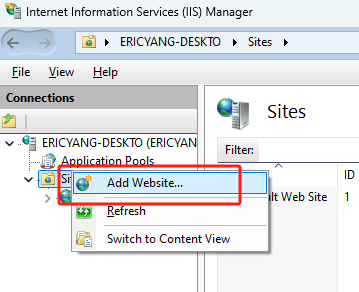

2. For the `site`, name the project as you want. For the `physical path`, type the path to the project. Click `OK`.

    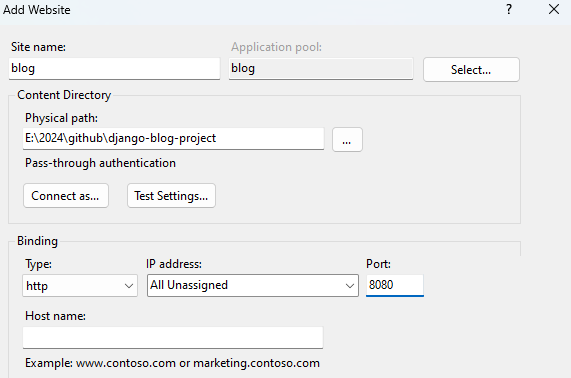

### Option 1: Set FastCGI Handler using IIS

Next, we’ll add a `FastCGI handler` mapping to this site so the requests coming into the site will be processed by the Django application.

1. In `IIS Manager`, expand the Sites folder on the left-hand side and click on the `site`. On the right, double-click `Handler Mappings`

   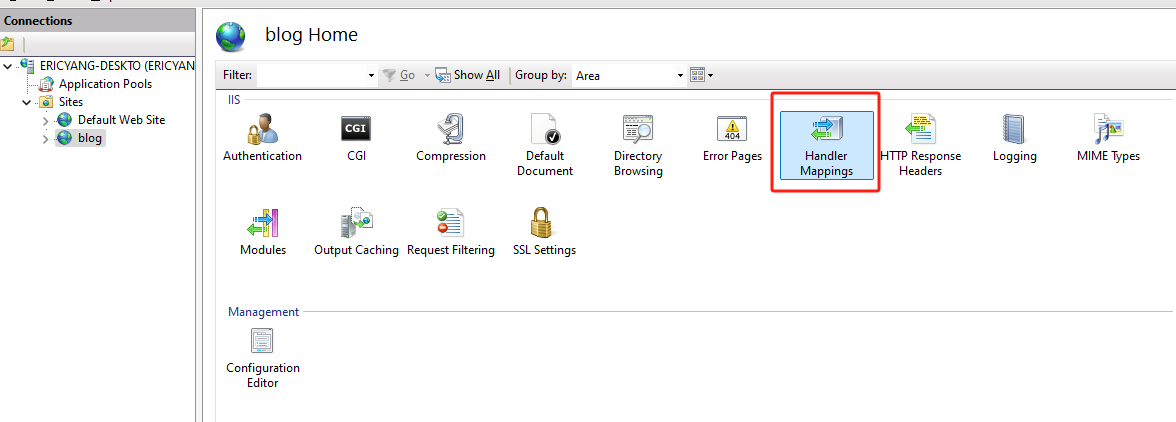

2. On the right, under `Actions,` click `Add Module Mapping`

   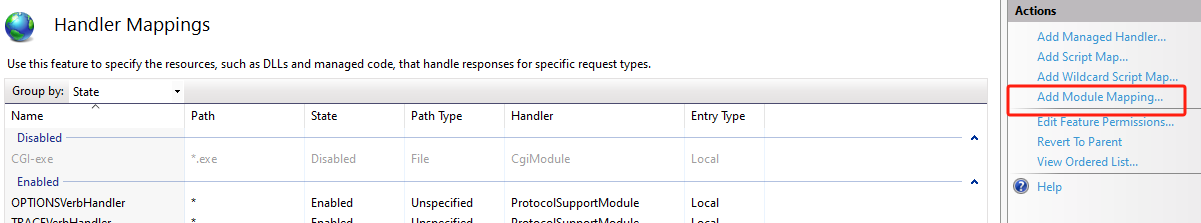

3. Fill out the form using your data

   1. `D:\Anaconda3\envs\py38\python.exe|D:\Anaconda3\envs\py38\Lib\site-packages\wfastcgi.py`

   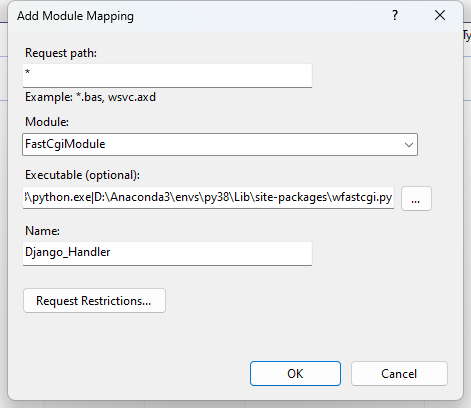

4. Click the `Request Restrictions` button and uncheck the `Invoke handler only if the request is mapped to` checkbox

    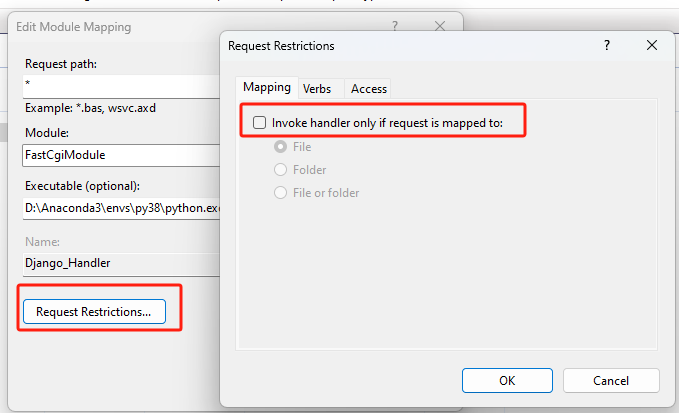

### Option 2: Set FastCGI Handler using `web.config`

- [Microsoft tutorial](https://learn.microsoft.com/en-us/visualstudio/python/configure-web-apps-for-iis-windows?view=vs-2022)

1. Build a `web.config` at under the same dir of `{Your Django Project}`, below is my `web.config` file

    ```xml
    <?xml version="1.0" encoding="utf-8"?>
    <configuration>
        <system.webServer>
            <handlers>
                <add name="Python FastCGI" path="*" verb="*" modules="FastCgiModule" scriptProcessor="D:\Anaconda3\envs\py38\python.exe|D:\Anaconda3\envs\py38\Lib\site-packages\wfastcgi.py" resourceType="Unspecified" requireAccess="Script" />
            </handlers>
        </system.webServer>

        <appSettings>
            <add key="WSGI_HANDLER" value="django.core.wsgi.get_wsgi_application()" />
            <add key="DJANGO_SETTINGS_MODULE" value="django_project.settings" />
            <add key="PYTHONPATH" value="E:\2024\github\django-blog-project\django_project" />
        </appSettings>
    </configuration>
    ```


## Load Static and Media file properly

### Gather all static files and make a static virtual path

- [Working with Static and Media Files in Django](https://testdriven.io/blog/django-static-files/)

1. run `python manage.py collectstatic` under your django project

   - It will generate `admin` under your `static` path, which contains all static files

   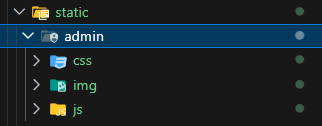

2. `Add Virtual Directory` in your site

   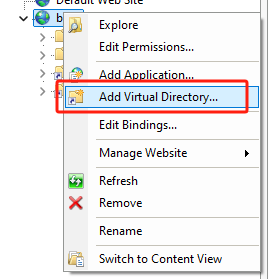

3. Fill the form using your `static` info

   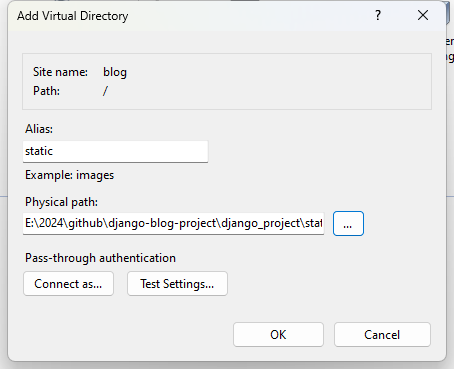

4. Put a `web.config` under your `static` folder

   ```xml
   <?xml version="1.0" encoding="UTF-8"?>
   <configuration>
      <system.webServer>
         <handlers>
               <clear />
               <add name="StaticFile" path="*" verb="*" modules="StaticFileModule" resourceType="File" requireAccess="Read" />
         </handlers>
      </system.webServer>
   </configuration>
   ```

### Do the same for `media`


## Check Result and Set Firewall

### Check Result

* At this point everything should be working, so verify by loading the application in a browser.
* Open a browser on the server, Browse to `http://localhost:{port number you set}`

### Configure the Windows Firewall

## Possible Error

### Python env issue 

  ```python
  Error occurred while reading WSGI handler:

  Traceback (most recent call last):
    ...
    File "D:\Anaconda3\envs\py38\lib\site-packages\django\apps\registry.py", line 83, in populate
      raise RuntimeError("populate() isn't reentrant")
  RuntimeError: populate() isn't reentrant


  StdOut: 

  StdErr: 
  ```

  *  open `django/apps/registry.py`,  and around line 80, replace: `raise RuntimeError("populate() isn't reentrant")` with `self.app_configs = {}`
  *  This will allow Django to continue loading, and **reveal the actual error**.